In [1]:
import pandas as pd
import numpy as np
import maddpkg
import matplotlib.pyplot as plt
import pickle

In [2]:
model = "NB"
sensitive_feature = "gender"

In [3]:
y_pp = pickle.load(open("./data_EDM23/y_pp_" + model + "_" + sensitive_feature, "rb"))
X_test = pd.read_csv("./data_courseBBB/X_test_stClick_7030.csv")

## Generation of h based on m

In [44]:
m = np.arange(1, 500, 1)
e = 1/m
e = e[::-1]

In [45]:
madd = [maddpkg.MADD(X_test, y_pp, sensitive_feature, ei) for ei in e]

In [46]:
print(len(madd))

499


## MADD min

In [6]:
madd_min_ind = np.argmin(madd)
print("MADD minimum:", madd[madd_min_ind])
print("e associated:", e[madd_min_ind])

MADD minimum: 0.0
e associated: 1.0


## Orders of h

In [7]:
n0 = len(X_test[X_test[sensitive_feature] == 0])
n1 = len(X_test[X_test[sensitive_feature] == 1])
order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)
print(n0)
print(n1)
print(order)

1404
186
0.21546010543476263


In [8]:
h_inf = 0.01*order
h_mid = 0.1*order
print(h_inf)
print(h_mid)

0.002154601054347626
0.021546010543476265


In [9]:
ind_e_inf = np.where(e <= h_inf)[0][-1]
ind_e_mid = np.where(e <= h_mid)[0][-1]
ind_e_sup_or_ind_order = np.where(e <= order)[0][-1]

## MADD(h) on [0, 1]

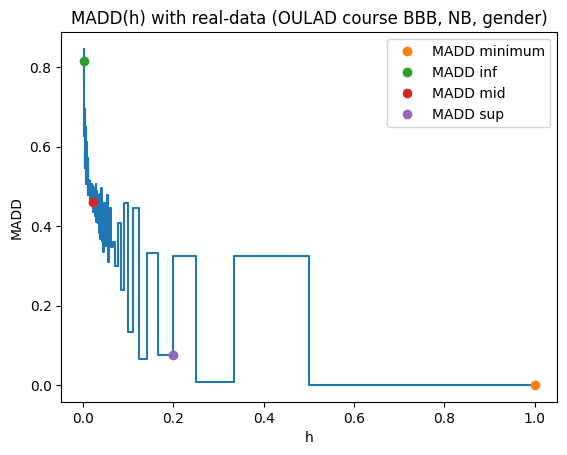

In [10]:
plt.step(e, madd)
plt.plot(e[madd_min_ind], madd[madd_min_ind], "o", label="MADD minimum")
plt.plot(e[ind_e_inf], madd[ind_e_inf], "o", label="MADD inf")
plt.plot(e[ind_e_mid], madd[ind_e_mid], "o", label="MADD mid")
plt.plot(e[ind_e_sup_or_ind_order], madd[ind_e_sup_or_ind_order], "o", label="MADD sup")
plt.xlabel("h")
plt.ylabel("MADD")
plt.title("MADD(h) with real-data (OULAD course BBB, " + model + ", " + sensitive_feature + ")")
plt.legend()

## MADD(e) focus on [0, 1]*optimal order

In [11]:
e = e[:ind_e_sup_or_ind_order+1]
madd = madd[:ind_e_sup_or_ind_order+1]
m = m[:ind_e_sup_or_ind_order+1]

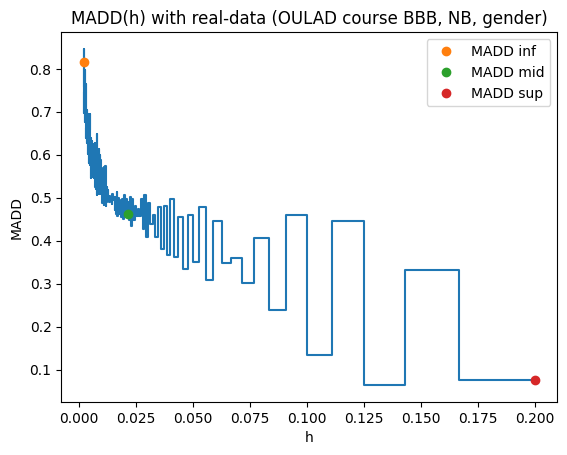

In [12]:
plt.step(e, madd, where="pre")
plt.plot(e[ind_e_inf], madd[ind_e_inf], "o", label="MADD inf")
plt.plot(e[ind_e_mid], madd[ind_e_mid], "o", label="MADD mid")
plt.plot(e[ind_e_sup_or_ind_order], madd[ind_e_sup_or_ind_order], "o", label="MADD sup")
plt.xlabel("h")
plt.ylabel("MADD")
plt.title("MADD(h) with real-data (OULAD course BBB, " + model + ", " + sensitive_feature + ")")
plt.legend()

In [13]:
ind_cv = np.where(e< 0.025)[0][-1]

In [14]:
madd[ind_cv]

0.4488558036945134

## Mean on [0, 1]*optimal order

In [15]:
np.mean(madd[ind_e_mid:ind_e_sup])

0.41121264239543803

## Variance of std

In [16]:
def calculate_std(y, start, end):
    """计算区间 [start, end] 内的标准差"""
    return np.std(y[start:end+1])

def find_stable_interval(y, min_length=10):
    n = len(y)
    # 初始化 dp 数组为无穷大
    #dp = [float('inf')] * n
    #dp[0] = 0  # 边界条件
    #interval = [(0, 0)] * n  # 记录每个子问题的最佳区间
    min_std = float('inf')
    interval = (0, 0)

    for i in range(min_length, n):
        for j in range(i - min_length + 1):
            std = calculate_std(y, j, i)
            if std < min_std:
                min_std = std
                interval = (j, i)

    return interval, min_std, np.average(y[interval[0]:interval[1]+1])

In [17]:
interval, std_min, avg = find_stable_interval(madd[ind_e_mid:], min_length=150)
print(interval, std_min, avg)

(0, 0) inf 0.4610329932910578


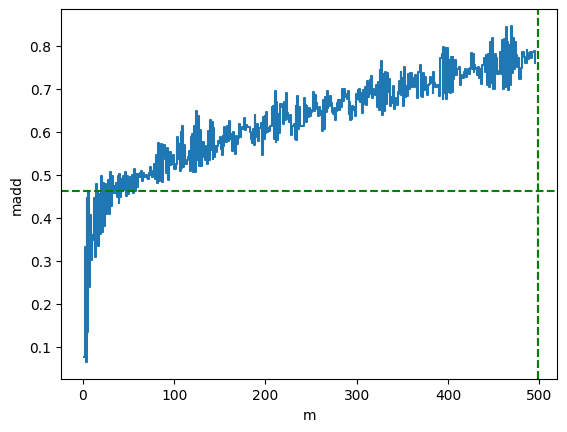

In [18]:
# plot the stable interval and the average y of the stable interval on the previous plot
plt.step(m[::-1], madd, where='pre')
# plot vertical lines at the optimal bandwidths
#plt.axvline(x=order, color='r', linestyle='--')
#plt.axvline(x=h_mid, color='r', linestyle='--')
#plt.axvline(x=h_inf, color='r', linestyle='--')
plt.axvline(x=1/e[interval[0]], color='g', linestyle='--')
plt.axvline(x=1/e[interval[1]], color='g', linestyle='--')
plt.axhline(y=avg, color='g', linestyle='--')
#plt.xlim(0,0.2)
plt.xlabel('m')
plt.ylabel('madd')
plt.show()

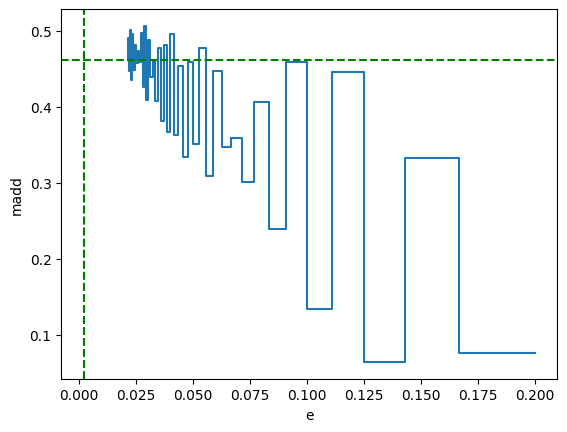

In [19]:
# plot the stable interval and the average y of the stable interval on the previous plot
plt.step(e, madd, where='pre')
# plot vertical lines at the optimal bandwidths
#plt.axvline(x=order, color='r', linestyle='--')
#plt.axvline(x=h_mid, color='r', linestyle='--')
#plt.axvline(x=h_inf, color='r', linestyle='--')
plt.axvline(x=e[interval[0]], color='g', linestyle='--')
plt.axvline(x=e[interval[1]], color='g', linestyle='--')
plt.axhline(y=avg, color='g', linestyle='--')
#plt.xlim(0,0.2)
plt.xlabel('e')
plt.ylabel('madd')
plt.show()

In [20]:
def find_stable_interval_advanced(x_list, y_list, min_interval_length=0.15):
    n = len(y_list)

    min_std = float('inf')
    interval = (0, 0)
    max_x = x_list[-1]

    for i in range(0, n):
        x_start = x_list[i]
        if x_start > max_x - min_interval_length:
            break
        x_min_sup = x_start + min_interval_length
        # find the index of the greatest x that is smaller than x_stop
        index_min_sup = np.searchsorted(x_list, x_min_sup, side='right') - 1
        for j in range(index_min_sup, n):
            std = calculate_std(y_list, i, j)
            if std < min_std:
                min_std = std
                interval = (i,j)

    return interval, min_std, np.average(y_list[interval[0]:interval[1]+1])

In [29]:
index = np.where(e<0.2)[0][-1]
y = madd[:index+1]
e = e[:index+1]
print(len(e), len(y))

494 494


In [34]:
interval, std_min, avg = find_stable_interval_advanced(e, madd, min_interval_length=0.025)

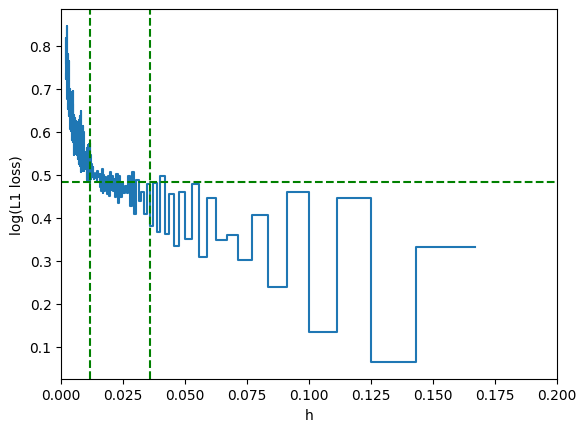

In [35]:


# plot the stable interval and the average y of the stable interval on the previous plot
plt.step(e, y, where='pre')
# plot vertical lines at the optimal bandwidths
#plt.axvline(x=1/sup_m, color='r', linestyle='--')
#plt.axvline(x=1/middle_m, color='r', linestyle='--')
#plt.axvline(x=1/inf_m, color='r', linestyle='--')
plt.axvline(x=e[interval[0]], color='g', linestyle='--')
plt.axvline(x=e[interval[1]], color='g', linestyle='--')
plt.axhline(y=avg, color='g', linestyle='--')
plt.xlim(0,0.2)
plt.xlabel('h')
plt.ylabel('log(L1 loss)')
plt.show()

## Advanced interval selection

In [26]:
def calculate_std(y, start, end):
    """计算区间 [start, end] 内的标准差"""
    return np.std(y[start:end+1])

def find_stable_interval_advanced(m_list, madd_list, n0=None, n1=None, min_interval_length=None, min_nb_points=50):
    # calculate the minimum of interval length if n0 and n1 are given and if min_interval_length is not given
    if n0 is None or n1 is None:
        if min_interval_length is None:
            min_interval_length = 0.05
    elif type(n0) is int and type(n1) is int:
        if min_interval_length is None:
            order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)
            min_interval_length = order * (1 - 0.1) / 2
    else:
        raise ValueError('n0 and n1 must be both None or both int')

    # reverse the lists
    h_list = (1/m_list)[::-1]
    y_list = madd_list[::-1]

    nb_y = len(y_list)

    # initialize the variables
    min_std = float('inf')
    interval = (0, 0)
    max_h = h_list[-1]

    for i in range(0, nb_y):
        x_start = h_list[i]
        # if the x_start is too big, we stop the loop
        if x_start > max_h - min_interval_length:
            break
        x_min_sup = x_start + min_interval_length
        # find the index of the greatest x that is smaller than x_stop
        index_min_sup = np.searchsorted(h_list, x_min_sup, side='right') - 1
        # if the number of points in the interval is too small, we continue the loop
        if index_min_sup - i < min_nb_points:
            continue
        # we calculate the std of the interval [i, j]
        for j in range(index_min_sup, nb_y):
            std = calculate_std(y_list, i, j)
            if std < min_std:
                min_std = std
                interval = (i,j)

    result = {'interval': interval, 'min_std': min_std, 'average': np.average(y_list[interval[0]:interval[1]+1]),
              'min_interval_length': min_interval_length}
    return result


def plot_stable_interval(m_list, madd_list, n0, n1, interval, zoom='None', show_order=True, show_stable=True):
    # reverse the lists
    h_list = (1 / m_list)[::-1]
    y_list = madd_list[::-1]

    # plot the stable interval and the average y of the stable interval on the previous plot
    plt.step(h_list, y_list, where="pre")

    order = ( (n0**(1/2) + n1**(1/2)) / (n0*n1)**(1/2) )**(2/3)
    # plot vertical lines at the optimal bandwidths
    if show_order:
        plt.axvline(x= 0.05 * order, color="r", linestyle="--")
        plt.axvline(x= 0.1 * order, color="r", linestyle="--")
        plt.axvline(x= order , color="r", linestyle="--")
    # plot vertical lines at the stable interval and the horizontal line at the average y of the stable interval
    if show_stable:
        plt.axvline(x=h_list[interval[0]], color="g", linestyle="--")
        plt.axvline(x=h_list[interval[1]], color="g", linestyle="--")
        plt.axhline(y=np.average(y_list[interval[0]:interval[1]+1]), color="g", linestyle="--")

    # zoom the plot
    if zoom == 'None':
        plt.xlim(0, np.max(h_list))
    elif zoom == 'sup order':
        plt.xlim(0, order)
    elif zoom == 'middle order':
        plt.xlim(0, 0.1 * order)
    elif zoom == 'inf order':
        plt.xlim(0, 0.05 * order)
    elif zoom == 'stable':
        plt.xlim(h_list[interval[0]], h_list[interval[1]])
    elif type(zoom) is tuple:
        plt.xlim(zoom[0], zoom[1])
    else:
        raise ValueError('zoom must be None, "sup order", "middle order", "inf order", "stable" or a tuple')

    plt.xlabel("h")
    plt.ylabel("MADD")
    plt.show()

In [47]:
result_stable = find_stable_interval_advanced(m, madd, n0, n1, min_interval_length=0.025, min_nb_points=50)

In [48]:
result_stable

{'interval': (408, 498),
 'min_std': 0.034168644965973154,
 'average': 0.7564854959395902,
 'min_interval_length': 0.025}

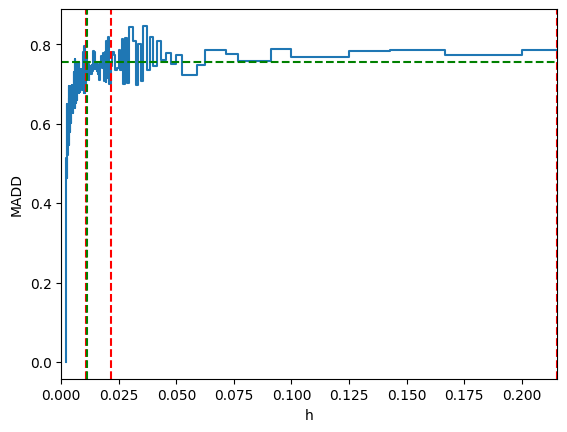

In [49]:
plot_stable_interval(m, madd, n0, n1, interval=result_stable['interval'], zoom='sup order')